# Country categorization for HELP International 

In this assignment, we categorize coutries to find out which amongst them are in dire need of aid

## Reading and understanding the data

In [1]:
# Importing the libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

In [2]:
#Importing the dataset
country_df = pd.read_csv("Country-data.csv")

In [3]:
# Top 5 rows
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


Inspecting various aspects of the dataframe 

In [4]:
country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


We don't need to perform null value elimination

In [5]:
country_df.shape

(167, 10)

#### According to the data dictionary, the columns `exports`, `health` and `imports` are given as a percentage of the GDP

#### Hence, calculating absolute values for the same

In [6]:
country_df['total_exports'] = (country_df['exports']*country_df['gdpp'])/100
country_df['total_health'] = (country_df['health']*country_df['gdpp'])/100
country_df['total_imports'] = (country_df['imports']*country_df['gdpp'])/100

In [7]:
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,total_exports,total_health,total_imports
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,55.30,41.9174,248.297
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,1145.20,267.8950,1987.740
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1712.64,185.9820,1400.440
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,2199.19,100.6050,1514.370
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,5551.00,735.6600,7185.800


In [8]:
#Dropping the original columns from the dataset as we don't need them anymore
country_df.drop(country_df[{'exports', 'health', 'imports'}], axis=1, inplace=True)

In [9]:
country_df.head()

,country,child_mort,income,inflation,life_expec,total_fer,gdpp,total_exports,total_health,total_imports
0,Afghanistan,90.2,1610,9.44,56.2,5.82,553,55.30,41.9174,248.297
1,Albania,16.6,9930,4.49,76.3,1.65,4090,1145.20,267.8950,1987.740
2,Algeria,27.3,12900,16.10,76.5,2.89,4460,1712.64,185.9820,1400.440
3,Angola,119.0,5900,22.40,60.1,6.16,3530,2199.19,100.6050,1514.370
4,Antigua and Barbuda,10.3,19100,1.44,76.8,2.13,12200,5551.00,735.6600,7185.800


## EDA and Data Visualization

### Univariate Analysis

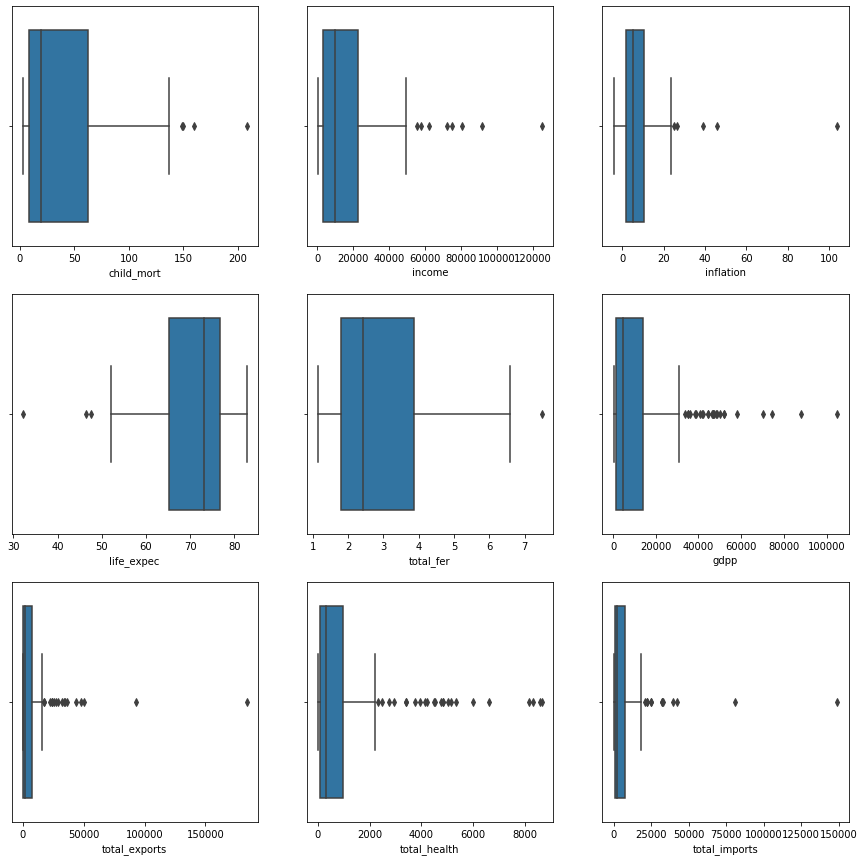

In [11]:
f = country_df.columns[1:]
plt.figure(figsize=(15,15))
for i in enumerate(f):
    plt.subplot(3,3,i[0]+1)
    sns.boxplot(x=i[1], data=country_df)

From the above plots, we can see that there are quite some outliers in `income`, `gdpp`, `total_exports`, `total_health`, and `total_imports`

For `income`, we can cap the higher level outliers since the aim of this assignment is to find the countries that need aid, which intuitively means the country does not have a high income 

In [12]:
country_df.head()

,country,child_mort,income,inflation,life_expec,total_fer,gdpp,total_exports,total_health,total_imports
0,Afghanistan,90.2,1610,9.44,56.2,5.82,553,55.30,41.9174,248.297
1,Albania,16.6,9930,4.49,76.3,1.65,4090,1145.20,267.8950,1987.740
2,Algeria,27.3,12900,16.10,76.5,2.89,4460,1712.64,185.9820,1400.440
3,Angola,119.0,5900,22.40,60.1,6.16,3530,2199.19,100.6050,1514.370
4,Antigua and Barbuda,10.3,19100,1.44,76.8,2.13,12200,5551.00,735.6600,7185.800


For handling outliers, soft capping will be used. However, taking a different approach for capping here.

Instead of capping all the upper and lower range values, capping will be performed intuitively, based on the discription of columns that is provided in the data dictionary

In [13]:
#Capping for income and inflation
soft1 = country_df.columns[2:4]

In [14]:
soft1

Index(['income', 'inflation'], dtype='object')

In [15]:
for i in soft1:
    q4 = country_df[i].quantile(0.99)
    country_df = country_df[(country_df[i]<=q4)]

In [16]:
#Capping for gdpp, total_exports, total_health, total_imports
soft2 = country_df.columns[6:10]

In [17]:
soft2

Index(['gdpp', 'total_exports', 'total_health', 'total_imports'], dtype='object')

In [18]:
for i in soft2:
    q4 = country_df[i].quantile(0.99)
    country_df = country_df[(country_df[i]<=q4)]

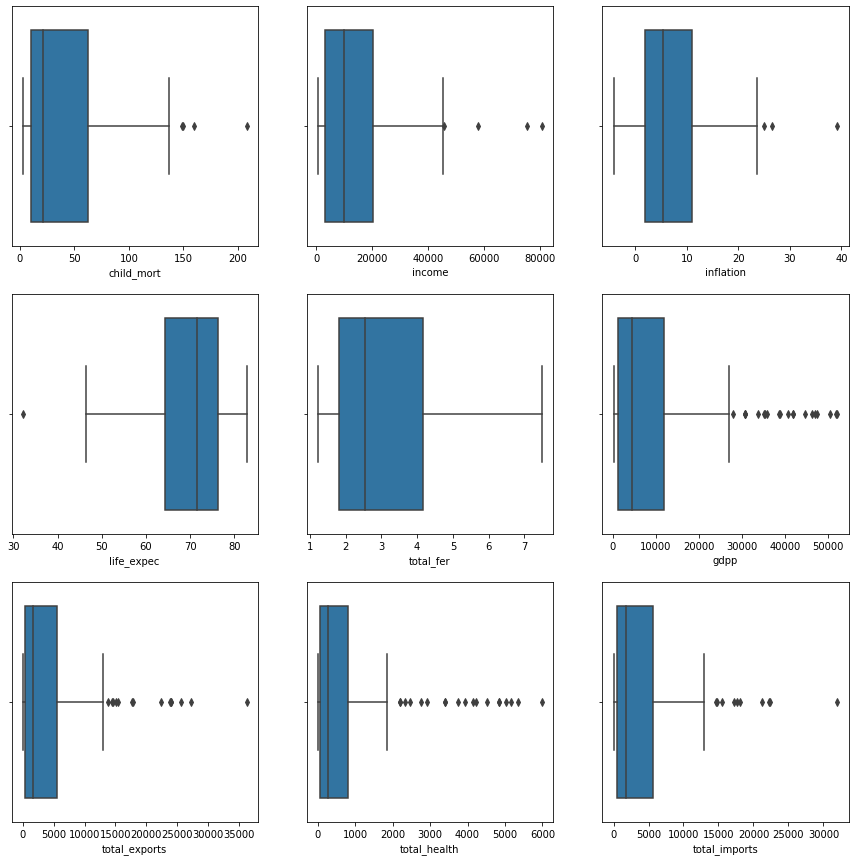

In [19]:
#Checking the data for outliers one more time
f = country_df.columns[1:]
plt.figure(figsize=(15,15))
for i in enumerate(f):
    plt.subplot(3,3,i[0]+1)
    sns.boxplot(x=i[1], data=country_df)

We can see that after the initial soft capping, there still are columns that have outliers. We will let these be for now as the columns having outliers in the higher range are indicating countries that are doing well. As for `child_mort`, since we have some outliers in the higher range, and this is indicative of the fact that the country may need aid because of the high mortality rate, we will not perform capping for `child_mort`

### Scaling and transformation

In [20]:
#Scaling
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
df_2 = ss.fit_transform(country_df.drop('country', axis=1))

In [21]:
#Converting to a dataframe
df_2 = pd.DataFrame(df_2)
df_2.columns = country_df.columns[1:]
df_2.head()

,child_mort,income,inflation,life_expec,total_fer,gdpp,total_exports,total_health,total_imports
0,1.252018,-0.869444,0.314450,-1.566515,1.854566,-0.721685,-0.675967,-0.581708,-0.721380
1,-0.582384,-0.302265,-0.400856,0.724466,-0.897963,-0.450424,-0.505840,-0.404054,-0.400732
2,-0.315698,-0.099799,1.276863,0.747262,-0.079465,-0.422048,-0.417266,-0.468451,-0.508994
3,1.969827,-0.576992,2.187253,-1.121996,2.078992,-0.493372,-0.341319,-0.535570,-0.487993
4,-0.739405,0.322859,-0.841600,0.781456,-0.581125,0.171552,0.181878,-0.036317,0.557474


### Bivariate Analysis

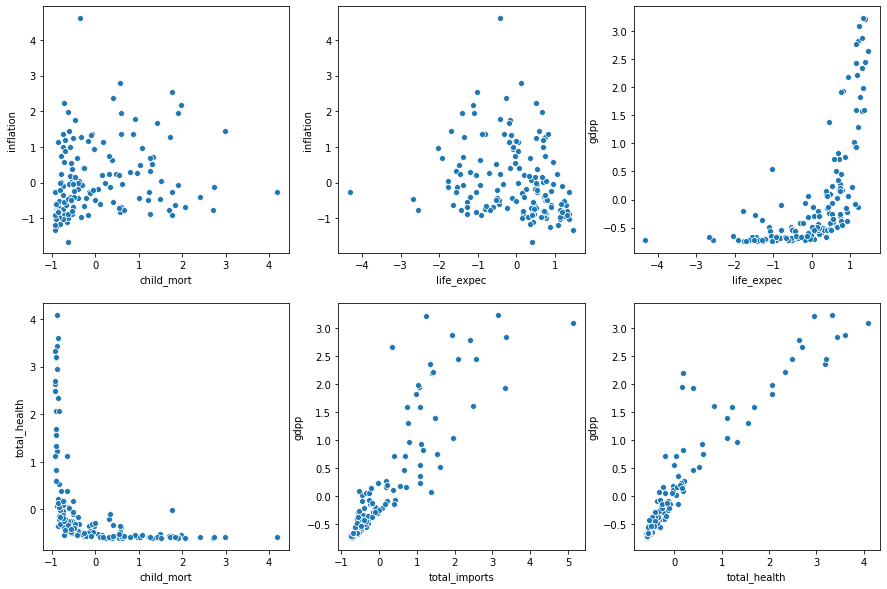

In [22]:
#Checking Scatter Plots
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
sns.scatterplot(x='child_mort', y='inflation', data=df_2)
plt.subplot(2,3,2)
sns.scatterplot(x='life_expec', y='inflation', data=df_2)
plt.subplot(2,3,3)
sns.scatterplot(x='life_expec', y='gdpp', data=df_2)
plt.subplot(2,3,4)
sns.scatterplot(x='child_mort', y='total_health', data=df_2)
plt.subplot(2,3,5)
sns.scatterplot(x='total_imports', y='gdpp', data=df_2)
plt.subplot(2,3,6)
sns.scatterplot(x='total_health', y='gdpp', data=df_2)

From the above plots, we can see some obvious relationship between `total_health` and `total_imports` with `gdpp`

Also, the relationship between `life_expec` and `gdpp` is clearly seen

#### Now, before we go ahead with clustering activities, we need to check how well can the given dataset be clustered

#### We will be using Hopkins Statistic for the same

In [23]:
#Running Hopkins
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [49]:
#Passing out dataset to the above function
hopkins(df_2)

0.8649459519784289

After running Hopkins a couple of times, we see that the value is about 0.86, which means that the given data does have a **good** cluster tendency

## KMeans Clustering

We need to find the number of Clusters required to perform KMeans.
Sihouette analysis will be used for the same

In [50]:
#Silhouette Analysis
from sklearn.metrics import silhouette_score
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df_2)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(df_2, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.48399365989717896
For n_clusters=3, the silhouette score is 0.4014792776642669
For n_clusters=4, the silhouette score is 0.3322793252469721
For n_clusters=5, the silhouette score is 0.33127968545708925
For n_clusters=6, the silhouette score is 0.2743624981360916
For n_clusters=7, the silhouette score is 0.29417614143872467
For n_clusters=8, the silhouette score is 0.2802979138107785


From the above silhouette scores, we can consider the number of clusters as 3

Let's check using the elbow curve method

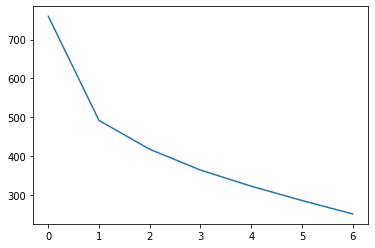

In [51]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df_2)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

The elbow curve plot is not very conclusive

In [52]:
# Model with k=3
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(df_2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [53]:
kmeans.labels_

array([0, 2, 2, 0, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
       1, 2, 0, 0, 2, 0, 1, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 1, 1, 2,
       2, 2, 2, 0, 0, 2, 2, 1, 1, 0, 0, 2, 1, 0, 1, 2, 2, 0, 0, 2, 0, 2,
       1, 2, 2, 2, 0, 1, 1, 2, 1, 2, 2, 0, 0, 1, 2, 0, 2, 2, 0, 0, 2, 2,
       2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 1, 1, 0, 1, 0,
       2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 0, 2, 2, 0, 1, 1, 0, 2, 1, 1, 2,
       2, 0, 2, 1, 2, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 1, 1, 2, 2, 2, 2, 0,
       0])

In [54]:
df_2.head()

,child_mort,income,inflation,life_expec,total_fer,gdpp,total_exports,total_health,total_imports
0,1.252018,-0.869444,0.314450,-1.566515,1.854566,-0.721685,-0.675967,-0.581708,-0.721380
1,-0.582384,-0.302265,-0.400856,0.724466,-0.897963,-0.450424,-0.505840,-0.404054,-0.400732
2,-0.315698,-0.099799,1.276863,0.747262,-0.079465,-0.422048,-0.417266,-0.468451,-0.508994
3,1.969827,-0.576992,2.187253,-1.121996,2.078992,-0.493372,-0.341319,-0.535570,-0.487993
4,-0.739405,0.322859,-0.841600,0.781456,-0.581125,0.171552,0.181878,-0.036317,0.557474


In [55]:
# Converting to Series
pd.Series(kmeans.labels_)

0      0
1      2
2      2
3      0
4      2
      ..
150    2
151    2
152    2
153    0
154    0
Length: 155, dtype: int32

In [56]:
#Adding the labels to the dataset
country_df['labels'] = kmeans.labels_

In [57]:
country_df.tail()

,country,child_mort,income,inflation,life_expec,total_fer,gdpp,total_exports,total_health,total_imports,labels
161,Uzbekistan,36.3,4240,16.50,68.8,2.34,1380,437.46,80.178,393.30,2
162,Vanuatu,29.2,2950,2.62,63.0,3.50,2970,1384.02,155.925,1565.19,2
164,Vietnam,23.3,4490,12.10,73.1,1.95,1310,943.20,89.604,1050.62,2
165,Yemen,56.3,4480,23.60,67.5,4.67,1310,393.00,67.858,450.64,0
166,Zambia,83.1,3280,14.00,52.0,5.40,1460,540.20,85.994,451.14,0


In [58]:
#Checking for null values 
country_df.isnull().sum()

country          0
child_mort       0
income           0
inflation        0
life_expec       0
total_fer        0
gdpp             0
total_exports    0
total_health     0
total_imports    0
labels           0
dtype: int64

In [59]:
#Count distribution in each cluster
country_df.labels.value_counts()

2    82
0    45
1    28
Name: labels, dtype: int64

In [60]:
#Cluster Profiling
#We can find out the cluster mean for various clusters

country_df.groupby('labels')[['gdpp', 'income', 'child_mort']].mean()

,gdpp,income,child_mort
labels,,,
0,1681.822222,3480.511111,92.468889
1,34721.428571,39189.285714,5.582143
2,6053.682927,11859.634146,22.895122


From the above, we can see that Cluster 0 definitely contains our target countries as it has mean values as:
- minimum gdpp
- minimum income
- maximum child_mort

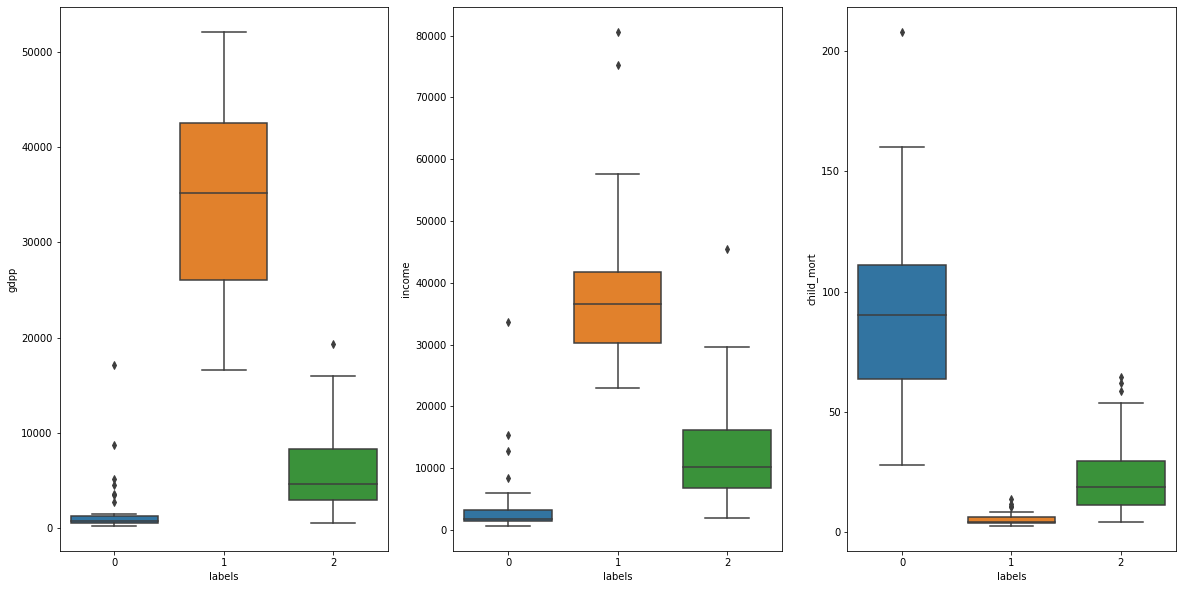

In [61]:
#Checking further using boxplot
f = ['gdpp', 'income', 'child_mort']
plt.figure(figsize=(20,10))
for i in enumerate(f):
    plt.subplot(1,3,i[0]+1)
    sns.boxplot(x='labels', y=i[1], data=country_df)

From the above plot, it proves our earlier notion that Cluster 0 has our target countries which are in need of aid

In [63]:
#Storing the result in another dataset
result_df = country_df[country_df['labels']==0]

In [64]:
result_df.head()

,country,child_mort,income,inflation,life_expec,total_fer,gdpp,total_exports,total_health,total_imports,labels
0,Afghanistan,90.2,1610,9.440,56.2,5.82,553,55.3000,41.9174,248.297,0
3,Angola,119.0,5900,22.400,60.1,6.16,3530,2199.1900,100.6050,1514.370,0
17,Benin,111.0,1820,0.885,61.8,5.36,758,180.4040,31.0780,281.976,0
25,Burkina Faso,116.0,1430,6.810,57.9,5.87,575,110.4000,38.7550,170.200,0
26,Burundi,93.6,764,12.300,57.7,6.26,231,20.6052,26.7960,90.552,0


In order to find our target countries, we need to sort the obtained resultant dataset

In [65]:
result_df.sort_values(by=['gdpp', 'child_mort', 'income'], ascending=[True, False, True]).head()

,country,child_mort,income,inflation,life_expec,total_fer,gdpp,total_exports,total_health,total_imports,labels
26,Burundi,93.6,764,12.30,57.7,6.26,231,20.6052,26.7960,90.552,0
88,Liberia,89.3,700,5.47,60.8,5.02,327,62.4570,38.5860,302.802,0
37,"Congo, Dem. Rep.",116.0,609,20.80,57.5,6.54,334,137.2740,26.4194,165.664,0
112,Niger,123.0,814,2.55,58.8,7.49,348,77.2560,17.9568,170.868,0
132,Sierra Leone,160.0,1220,17.20,55.0,5.20,399,67.0320,52.2690,137.655,0


### "*Burundi*", "*Liberia*", "*Congo, Dem. Rep.*", "*Niger*" and "*Sierra Leone*" are the countries in immediate need of aid according to KMeans Clustering

## Hierarchical Clustering

In [66]:
df_2.head()

,child_mort,income,inflation,life_expec,total_fer,gdpp,total_exports,total_health,total_imports
0,1.252018,-0.869444,0.314450,-1.566515,1.854566,-0.721685,-0.675967,-0.581708,-0.721380
1,-0.582384,-0.302265,-0.400856,0.724466,-0.897963,-0.450424,-0.505840,-0.404054,-0.400732
2,-0.315698,-0.099799,1.276863,0.747262,-0.079465,-0.422048,-0.417266,-0.468451,-0.508994
3,1.969827,-0.576992,2.187253,-1.121996,2.078992,-0.493372,-0.341319,-0.535570,-0.487993
4,-0.739405,0.322859,-0.841600,0.781456,-0.581125,0.171552,0.181878,-0.036317,0.557474


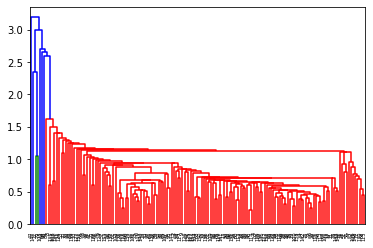

In [67]:
# single linkage

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

mergings = linkage(df_2, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

Trying out with single linkage for now

In [68]:
# 3 clusters
cluster_labels1 = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0])

In [69]:
# assign cluster labels
country_df['cluster_labels1'] = cluster_labels1
country_df.head()

,country,child_mort,income,inflation,life_expec,total_fer,gdpp,total_exports,total_health,total_imports,labels,cluster_labels1
0,Afghanistan,90.2,1610,9.44,56.2,5.82,553,55.30,41.9174,248.297,0,0
1,Albania,16.6,9930,4.49,76.3,1.65,4090,1145.20,267.8950,1987.740,2,0
2,Algeria,27.3,12900,16.10,76.5,2.89,4460,1712.64,185.9820,1400.440,2,0
3,Angola,119.0,5900,22.40,60.1,6.16,3530,2199.19,100.6050,1514.370,0,0
4,Antigua and Barbuda,10.3,19100,1.44,76.8,2.13,12200,5551.00,735.6600,7185.800,2,0


In [70]:
country_df.cluster_labels1.value_counts()

0    151
1      3
2      1
Name: cluster_labels1, dtype: int64

From the above distribution of clusters, we can see that something is not right in the clustering. This could be because we have used single linkage and in single linkage, we face the problem of chaining as read in:

https://nlp.stanford.edu/IR-book/html/htmledition/single-link-and-complete-link-clustering-1.html

Now we will be going ahead with complete linkage

In [72]:
#Dropping the initial cluster labels created in single linkage
country_df.drop(country_df[{'cluster_labels1'}], axis=1, inplace=True)

In [73]:
country_df.head()

,country,child_mort,income,inflation,life_expec,total_fer,gdpp,total_exports,total_health,total_imports,labels
0,Afghanistan,90.2,1610,9.44,56.2,5.82,553,55.30,41.9174,248.297,0
1,Albania,16.6,9930,4.49,76.3,1.65,4090,1145.20,267.8950,1987.740,2
2,Algeria,27.3,12900,16.10,76.5,2.89,4460,1712.64,185.9820,1400.440,2
3,Angola,119.0,5900,22.40,60.1,6.16,3530,2199.19,100.6050,1514.370,0
4,Antigua and Barbuda,10.3,19100,1.44,76.8,2.13,12200,5551.00,735.6600,7185.800,2


Using the complete linkage method

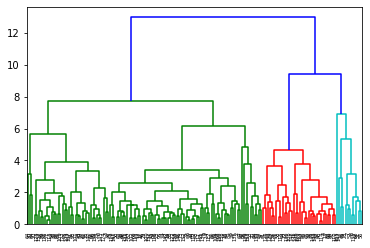

In [74]:
# complete linkage
mergings = linkage(df_2, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [75]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, 0, 1, 0, 0, 2, 2, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 2, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       2, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0,
       0])

In [76]:
# assign cluster labels
country_df['cluster_labels'] = cluster_labels
country_df.head()

,country,child_mort,income,inflation,life_expec,total_fer,gdpp,total_exports,total_health,total_imports,labels,cluster_labels
0,Afghanistan,90.2,1610,9.44,56.2,5.82,553,55.30,41.9174,248.297,0,0
1,Albania,16.6,9930,4.49,76.3,1.65,4090,1145.20,267.8950,1987.740,2,0
2,Algeria,27.3,12900,16.10,76.5,2.89,4460,1712.64,185.9820,1400.440,2,0
3,Angola,119.0,5900,22.40,60.1,6.16,3530,2199.19,100.6050,1514.370,0,0
4,Antigua and Barbuda,10.3,19100,1.44,76.8,2.13,12200,5551.00,735.6600,7185.800,2,1


In [77]:
country_df.cluster_labels.value_counts()

0    109
1     34
2     12
Name: cluster_labels, dtype: int64

We do obtain a better result using complete-linkage

In [78]:
#Cluster profiling
#We can find out the cluster mean for various clusters

country_df.groupby('cluster_labels')[['gdpp', 'income', 'child_mort']].mean()

,gdpp,income,child_mort
cluster_labels,,,
0,3323.522936,7145.990826,53.664220
1,19238.823529,25426.470588,8.214706
2,43991.666667,48583.333333,5.508333


Cluster 0 seems to be our target cluster

Let's check using the plots too

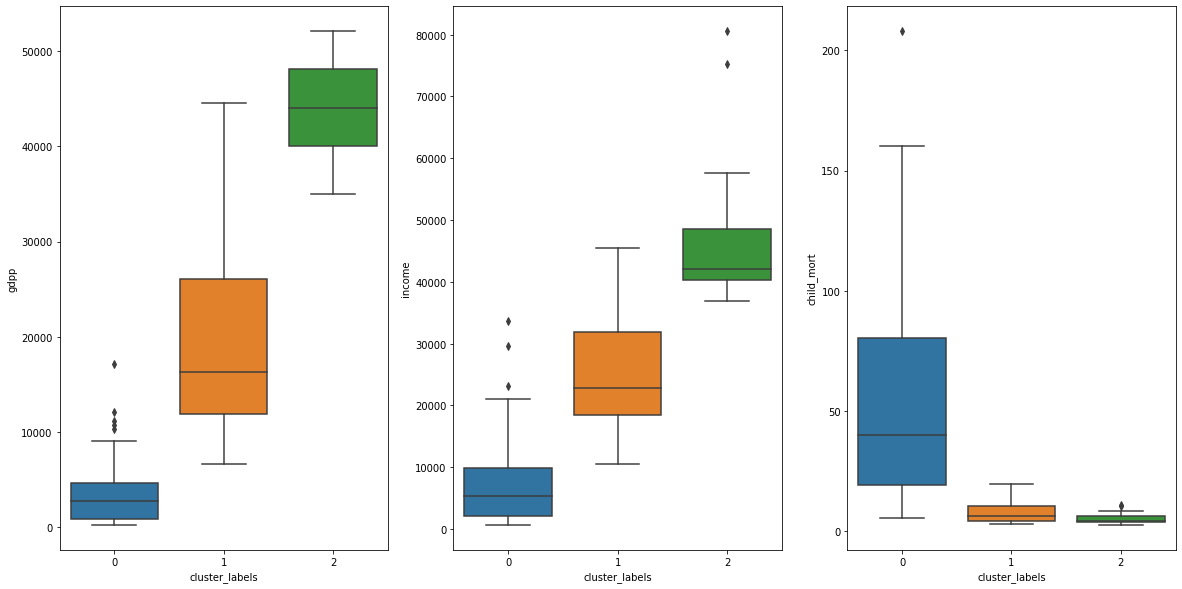

In [79]:
f = ['gdpp', 'income', 'child_mort']
plt.figure(figsize=(20,10))
for i in enumerate(f):
    plt.subplot(1,3,i[0]+1)
    sns.boxplot(x='cluster_labels', y=i[1], data=country_df)

The plots confirm that Cluster 0 does have the target countries which are in need of aid

In [80]:
result_df2 = country_df[country_df['cluster_labels']==0]

In [81]:
result_df2.sort_values(by=['gdpp', 'child_mort', 'income'], ascending=[True, False, True]).head()

,country,child_mort,income,inflation,life_expec,total_fer,gdpp,total_exports,total_health,total_imports,labels,cluster_labels
26,Burundi,93.6,764,12.30,57.7,6.26,231,20.6052,26.7960,90.552,0,0
88,Liberia,89.3,700,5.47,60.8,5.02,327,62.4570,38.5860,302.802,0,0
37,"Congo, Dem. Rep.",116.0,609,20.80,57.5,6.54,334,137.2740,26.4194,165.664,0,0
112,Niger,123.0,814,2.55,58.8,7.49,348,77.2560,17.9568,170.868,0,0
132,Sierra Leone,160.0,1220,17.20,55.0,5.20,399,67.0320,52.2690,137.655,0,0


### "*Burundi*", "*Liberia*", "*Congo, Dem. Rep.*", "*Niger*" and "*Sierra Leone*" are the countries in immediate need of aid according to Hierarchical Clustering

## Comparing our results from KMeans and Hierarchical Clustering, we see the countries in dire need of aid are:
- Burundi
- Liberia
- Congo, Dem. Rep.
- Niger
- Sierra Leone

Checking the clusters using plots

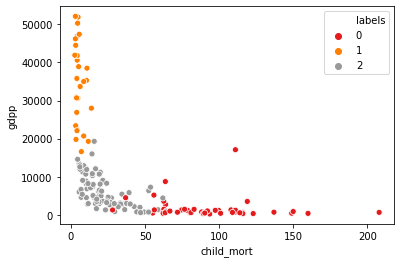

In [82]:
sns.scatterplot(x='child_mort', y='gdpp', hue='labels', data=country_df, palette='Set1')

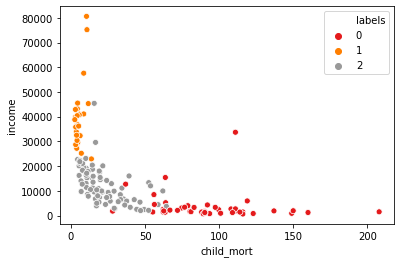

In [83]:
sns.scatterplot(x='child_mort', y='income', hue='labels', data=country_df, palette='Set1')

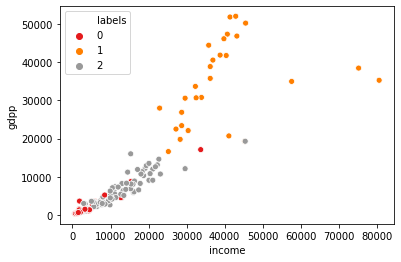

In [84]:
sns.scatterplot(x='income', y='gdpp', hue='labels', data=country_df, palette='Set1')

From the above plots, we can see the three different clusters based on `income`, `gdpp` and `child_mort`